In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
sns.set(style = 'white', font_scale=1.6)

In [19]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from scipy.stats import mannwhitneyu, pointbiserialr

def mannwhitneyu_p(X: pd.DataFrame, y: pd.Series, loo=True) -> float:
    if not loo:    
        group1 = X[y == 'NR']
        group2 = X[y == 'R']
        u_stat, p_value = mannwhitneyu(group1, group2)
    else:
        p_value = []
        for sidx in tqdm(X.index, ascii=True):
            used_idx = X.index.difference([sidx])
            X1 = X.loc[used_idx]
            group1 = X1[y.loc[used_idx] == 'NR']
            group2 = X1[y.loc[used_idx] == 'R']
            
            u_stat, p = mannwhitneyu(group1, group2)   
            p_value.append(p)
            
    return p_value


def pbc_corrleation(X: pd.DataFrame, y: pd.Series, loo=True) -> float:
    """
    Calculate the explained variance for a generalized linear model (GLM)
    with a binary response variable.
    Ref: https://www.nature.com/articles/nature25501/figures/11

    Description: Logistic regression pseudo-R2 was extracted as a measure of “explained variance”
    in patient response (i.e., the percent of variation in patient response that can be attributed
    to the contributions of the biological inputs)
    
    Args:
    X (pd.DataFrame): The feature values (can have multiple columns).
    y (pd.Series): The response labels, with 'R' for response and 'NR' for no response.
    
    Returns:
    float: The pseudo R-squared for the model, a measure of explained variance.
    """
    # Encode the response variable ('R' and 'NR') to numeric values

    if not loo:
        pbc, p = pointbiserialr(X, y.map({'R':1, 'NR':0}))
        ev = abs(pbc)
    else:
        ev = []
        for sidx in tqdm(X.index, ascii=True):
            used_idx = X.index.difference([sidx])
            X1 = X.loc[used_idx]
            pbc, p = pointbiserialr(X1, y.loc[used_idx].map({'R':1, 'NR':0}))
            ev.append(abs(pbc))
    return ev



def explained_variance(X: pd.DataFrame, y: pd.Series, loo=True) -> float:
    """
    Calculate the explained variance for a generalized linear model (GLM)
    with a binary response variable.
    Ref: https://www.nature.com/articles/nature25501/figures/11

    Description: Logistic regression pseudo-R2 was extracted as a measure of “explained variance”
    in patient response (i.e., the percent of variation in patient response that can be attributed
    to the contributions of the biological inputs)
    
    Args:
    X (pd.DataFrame): The feature values (can have multiple columns).
    y (pd.Series): The response labels, with 'R' for response and 'NR' for no response.
    
    Returns:
    float: The pseudo R-squared for the model, a measure of explained variance.
    """
    # Encode the response variable ('R' and 'NR') to numeric values

    if not loo:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
        # Add a constant to the features for the intercept term
        X_with_intercept = sm.add_constant(X)
    
        # Fit a logistic regression model using statsmodels, which provides pseudo R-squared
        glm_binom = sm.GLM(y_encoded, X_with_intercept, family=sm.families.Binomial())
        glm_result = glm_binom.fit()
        ev = glm_result.pseudo_rsquared()*100 #%
    else:
        ev = []
        for sidx in tqdm(X.index, ascii=True):
            used_idx = X.index.difference([sidx])
        
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y.loc[used_idx])
            # Add a constant to the features for the intercept term
            X_with_intercept = sm.add_constant(X.loc[used_idx])

            glm_binom = sm.GLM(y_encoded, X_with_intercept, family=sm.families.Binomial())
            glm_result = glm_binom.fit()
            res = glm_result.pseudo_rsquared()       
            ev.append(res*100 )
    return ev

In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor import loadconceptor
from conceptor.tokenizer import CANCER_CODE, CONCEPT_palette, CONCEPT

CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()

In [4]:
data_path = '/home/was966/Research/mims-conceptor/paper/00_data/'
dfl = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
dfl.cohort.unique()

array(['IMVigor210', 'Rose', 'Snyder', 'Zhao', 'Choueiri', 'IMmotion150',
       'Miao', 'SU2CLC1', 'SU2CLC2', 'Allen', 'Gide', 'Hugo', 'Liu',
       'MGH', 'Riaz', 'Kim'], dtype=object)

In [5]:
dfc_avg = pd.read_csv('../00_mean_score/02_avgAbd_readouts_celltype.csv', index_col=0)
dfc_gsea = pd.read_csv('../00_GSEA_score/02_ssgsea_readouts_celltype.csv', index_col=0)
dfc_pt = pd.read_csv('../00_PT_score/02_pt_readouts_celltype.csv', index_col=0)
dfc_pft = pd.read_csv('./01_get_score/02_loco_pft_readouts_celltype.csv', index_col=0)


In [6]:
train_idx = dfl.index
test_idx = dfl.index

In [7]:
print(len(train_idx), len(test_idx))

1133 1133


In [8]:
import scipy
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr

def annotate(ax, data, x, y, x_loc = 0.1):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(x_loc, .9, f'$r$={rvalue:.2f}', transform=ax.transAxes,fontsize=20) #, $p$={pvalue:.2g}

y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'

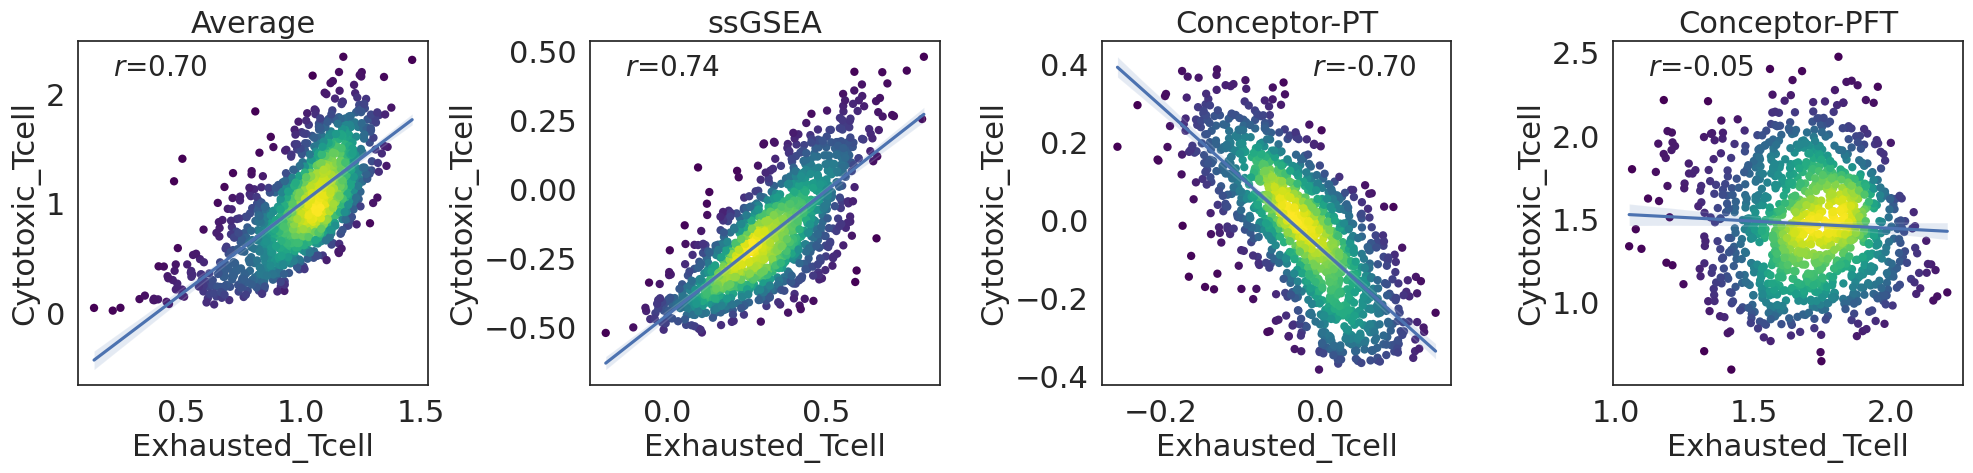

In [9]:
fig, axes = plt.subplots(figsize=(5*4, 5), ncols=4, sharex=False,  sharey=False)

from scipy import stats


xlocs = [0.1, 0.1, 0.6, 0.1]
datas = [dfc_avg, dfc_gsea, dfc_pt, dfc_pft]
names = ['Average', 'ssGSEA', 'Conceptor-PT', 'Conceptor-PFT']
for ax, data, xloc, name in zip(axes, datas, xlocs, names):

    data = data.loc[train_idx]
    values = np.vstack([data[y1], data[y2]])
    kernel = stats.gaussian_kde(values)(values)
    sns.scatterplot(data = data, x = y1, y = y2,  legend = False, ax = ax, c=kernel,cmap="viridis",edgecolor=None, linewidth=0, )
    sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax,  )
    annotate(ax, data, y1, y2, x_loc = xloc)
    ax.set_title(name , fontsize=22)

    ax.tick_params(axis='both', which='major', labelsize=22)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=22)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22)


fig.tight_layout(w_pad = 0.1)
fig.savefig('00_Cyt_ExhT_corr.svg', bbox_inches = 'tight')

1133
1133
1133


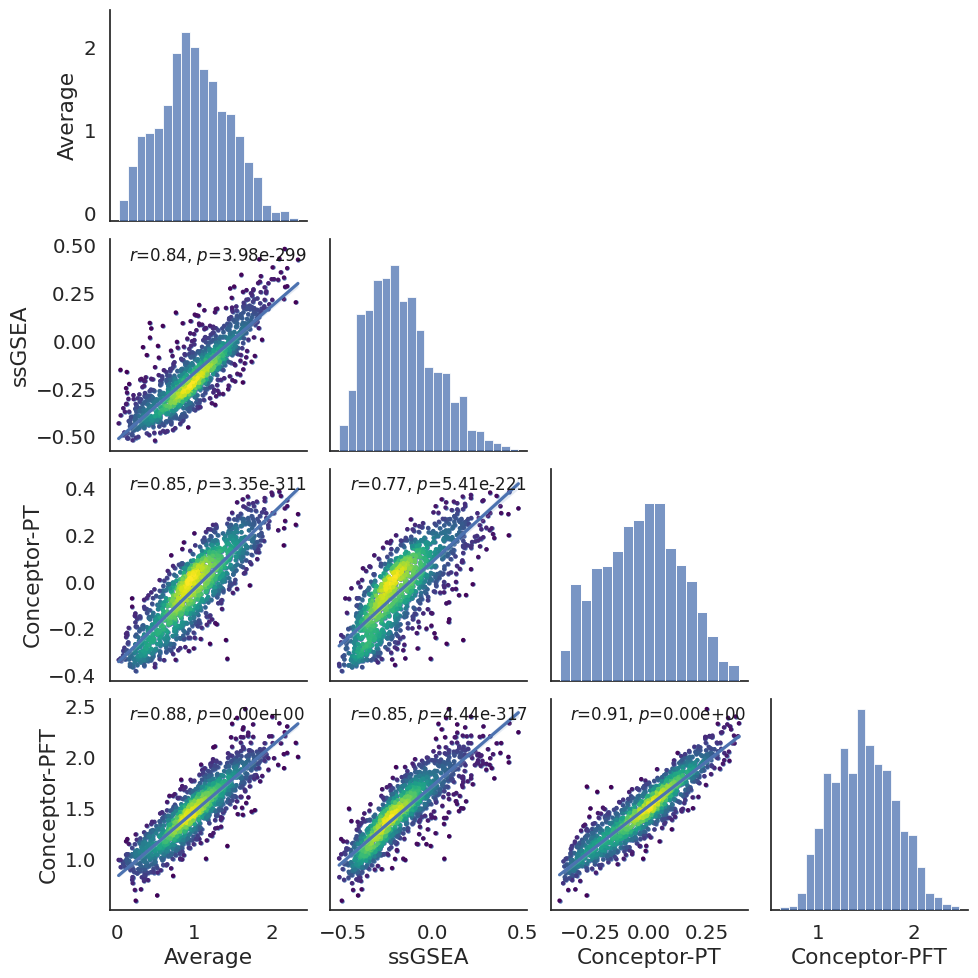

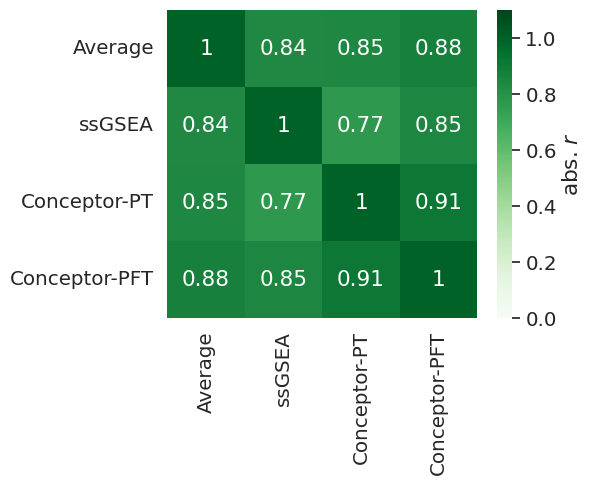

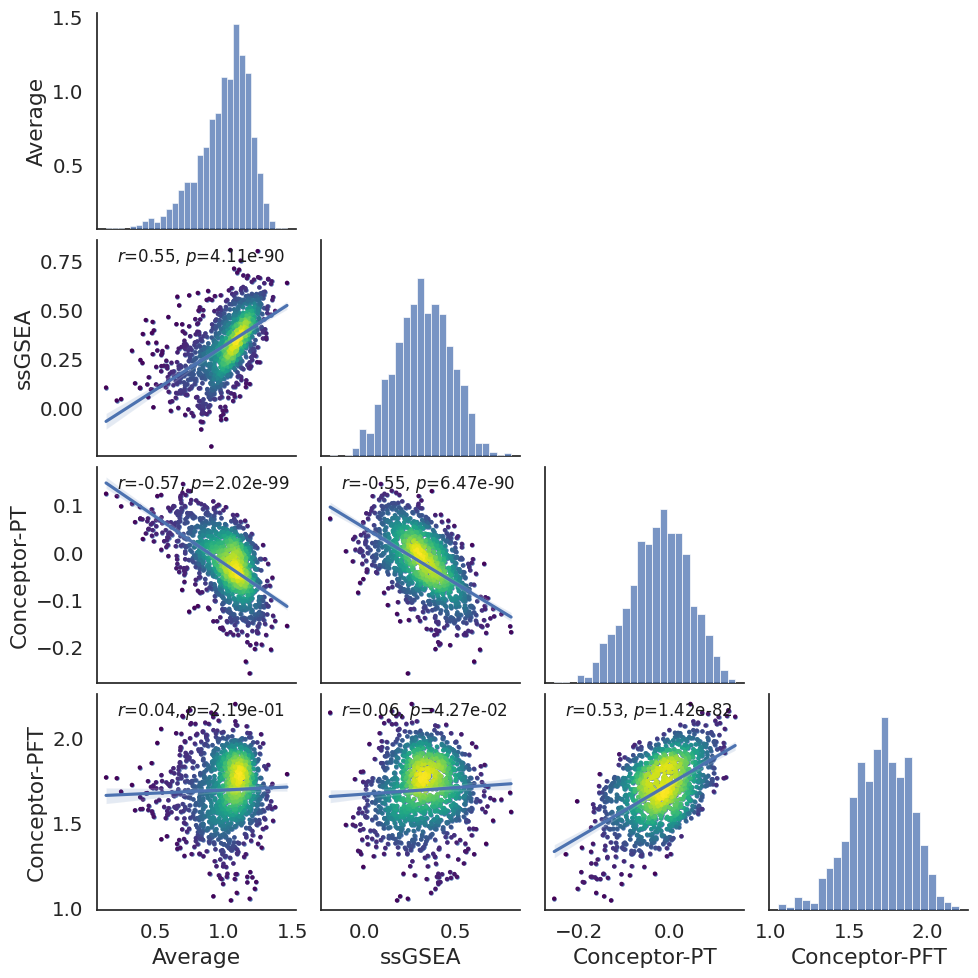

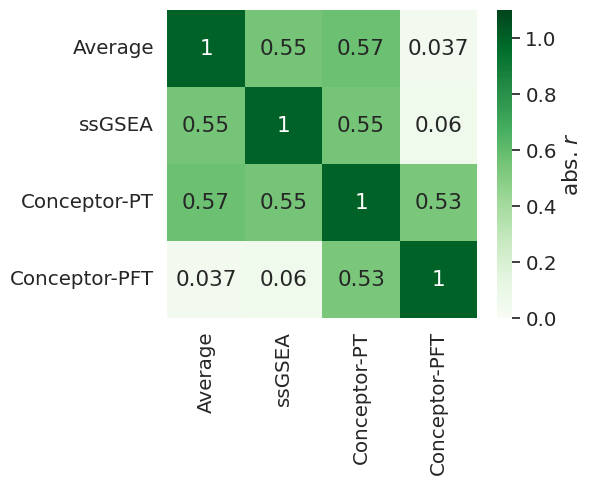

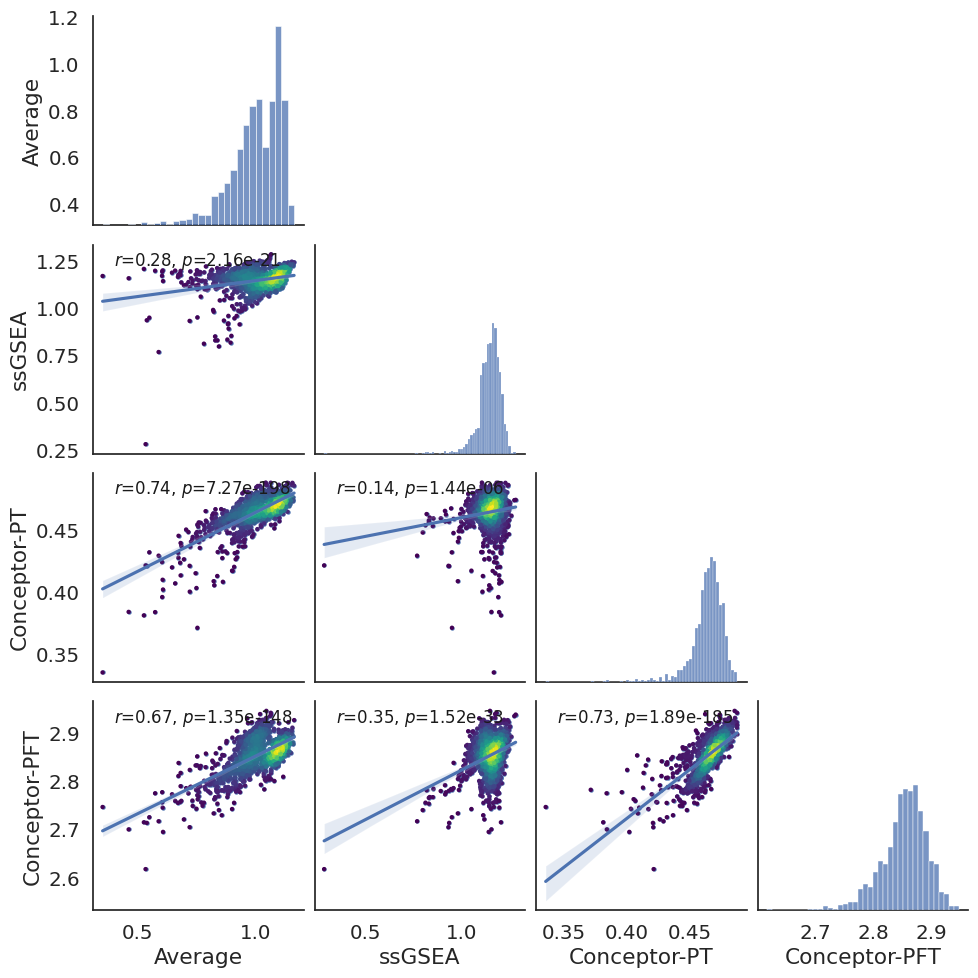

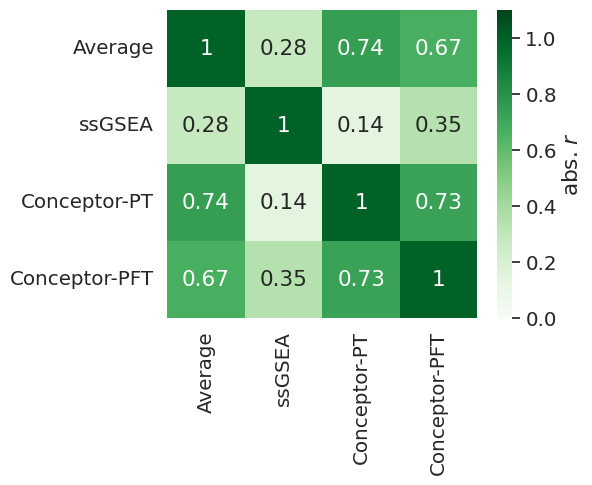

In [10]:
for v in ['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference']:
    df1 = dfc_avg[[v]] #,'Cytotoxic_Tcell'
    df1.columns = ['Average']
    
    df2 = dfc_gsea[[v]]
    df2.columns = ['ssGSEA']
    
    df3 = dfc_pt[[v]]
    df3.columns = ['Conceptor-PT']
    
    df4 = dfc_pft[[v]]
    df4.columns = ['Conceptor-PFT']
    
    df = df1.join(df2).join(df3).join(df4)
    df = df.loc[train_idx]
    
    print(len(df))
    
    
    def scatter_with_density(x, y, **kwargs):
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)(values)
        sns.scatterplot(x=x, y=y,  legend = False, c=kernel,cmap="viridis", s=10, edgecolor=None, linewidth=0, **kwargs)
        sns.regplot(x=x, y=y,scatter=False, **kwargs)
    
    g = sns.pairplot(df,  kind="scatter", plot_kws={'s': 10, 'linewidth': 0} ) #, hue = 'response_label', hue = 'response_label', #plot_kws={'scatter_kws': {'s': 10}}
    
    # 遍历每个子图，只显示下半角
    for i in range(len(g.axes)):
        for j in range(len(g.axes)):
            if i < j:
                g.axes[i, j].set_visible(False)  # 隐藏上三角的子图
            elif i > j:
                x = df[g.x_vars[j]]
                y = df[g.y_vars[i]]
                r, p = pearsonr(x, y)
                ax = g.axes[i, j]
                scatter_with_density(x, y, ax=ax)
                ax.annotate(f'$r$={r:.2f}, $p$={p:.2e}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12, color='k')
    
    plt.savefig("01_pairplot_%s.svg" % v , bbox_inches = 'tight')
    
    
    fig, ax = plt.subplots(figsize=(5, 4))
    corr = df.corr().abs()
    
    sns.heatmap(corr, ax=ax, annot=True, cmap = 'Greens', cbar_kws={'label':'abs. $r$'}, vmax = corr.max().max()+0.1, vmin = 0.0)
    fig.savefig("02_heatmap_corr_%s.svg" % v , bbox_inches = 'tight')


R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:5.216e-04 U_stat=1.538e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:5.692e-10 U_stat=1.676e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:6.960e-06 U_stat=1.590e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:5.460e-08 U_stat=1.637e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:1.144e-01 U_stat=1.281e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:2.996e-03 U_stat=1.512e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:2.613e-07 U_stat=1.100e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:4.835e-06 U_stat=1.130e+05
R(CR/PR)
(n=346) vs. NR(PD/SD)
(n=787): Mann-Whitney-Wilcoxon test two-sided, P_val:3.500e-03 U_stat=1.213e+05
R

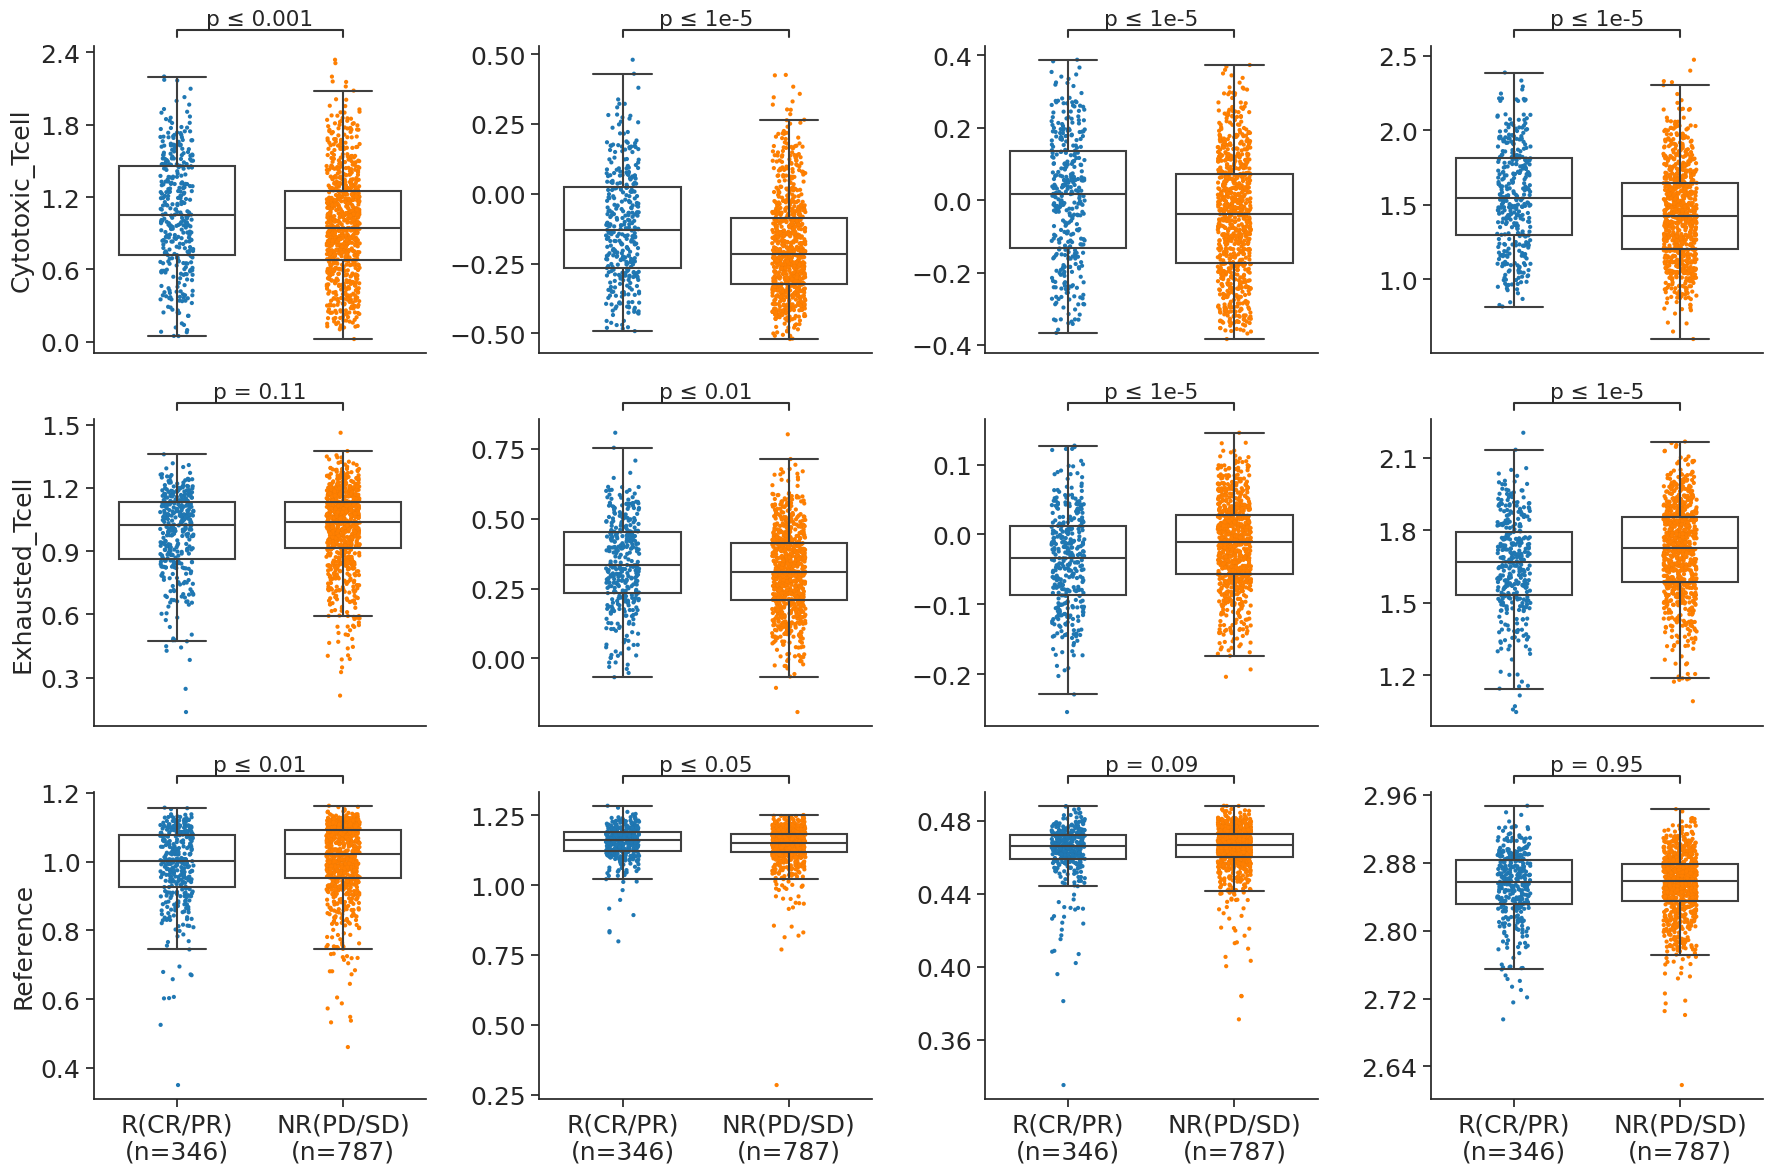

In [11]:
response_order = ['R', 'NR']
cm = sns.color_palette("Paired", 10)
palette =  [cm[1], cm[7]] #[bright[-2], bright[-1]]


fig, axes = plt.subplots(figsize=(18,12), nrows = 3, ncols = 4, sharex=True, sharey = False)

import matplotlib.ticker as ticker
import scipy
from statannotations.Annotator import Annotator

for v, rowax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes):
    
    df1 = dfc_avg[[v]] #,'Cytotoxic_Tcell' Exhausted_Tcell
    df1.columns = ['Average']
    
    df2 = dfc_gsea[[v]]
    df2.columns = ['ssGSEA']
    
    df3 = dfc_pt[[v]]
    df3.columns = ['Conceptor-PT']
    
    df4 = dfc_pft[[v]]
    df4.columns = ['Conceptor-PFT']
    
    df = df1.join(df2).join(df3).join(df4)   
    
    dfa = df.join(dfl['response_label']) 
    
    ### feature explain varince on test set only
    
    dfa = dfa.loc[test_idx]
    
    for c, ax in zip(df.columns, rowax):
        
        x = 'response_label'
        dfp = dfa[[c]].join(dfa[x]) 

        dfp[x] = dfp[x].map({'R':'R(CR/PR)', 'NR':'NR(PD/SD)'})
        size = dfp.groupby(x).size()
        size = size.index + "\n(n=" + size.astype(str) + ')'
        response_map = size.to_dict()
        dfp[x] = dfp[x].map(response_map)
        x_order = dfp.groupby(x).size().sort_values().index.tolist()
        
        sns.boxplot(data = dfp, x = x, y = c, order =x_order,
                    ax=ax, width = .7, fliersize=0,palette = palette, boxprops={'facecolor':'None'}, saturation=1) #palette = palette, 
        sns.stripplot(data = dfp, x = x, y = c, order =x_order,zorder = 0.5,size=3,linewidth = 0.01,
                    ax=ax, palette = palette) #palette = palette, boxprops={'facecolor':'None'}
        if v == 'Reference':
            ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
        if c == 'Average':
            ax.set_ylabel(v)
        else:
            ax.set_ylabel(None)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(None)
        
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
        
        
        box_pairs = [x_order]
        annotator = Annotator(ax, pairs=box_pairs, data=dfp, x=x, y=c, order=x_order)
        annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside', show_test_name = False,
                            #pvalue_format = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]],
                            comparisons_correction = None,)
        annotator.apply_and_annotate()

        ax.tick_params(axis='both', which='major', labelsize=18)
        
        # 设置坐标轴名字字体大小
        ax.set_xlabel(ax.get_xlabel(), fontsize=18)
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
    
fig.tight_layout()
fig.savefig("03_boxplot_feature.svg"  , bbox_inches = 'tight')


100%|##########| 1133/1133 [00:03<00:00, 362.52it/s]


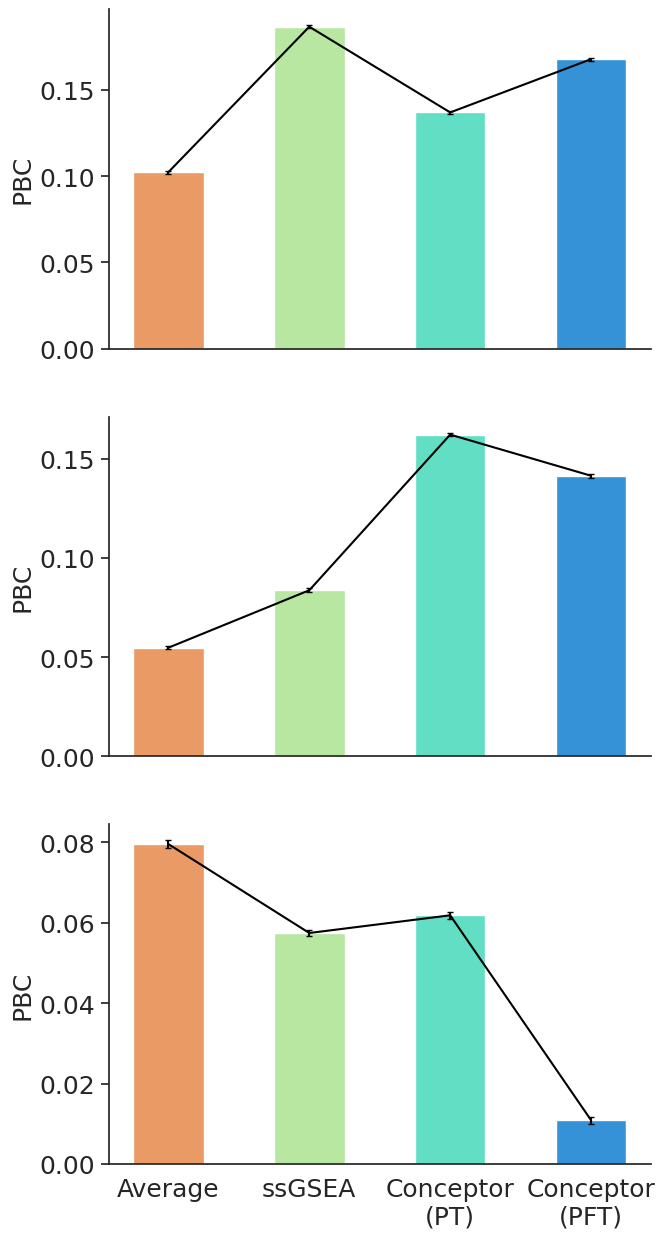

In [20]:
method = 'pbc'
fig, axes = plt.subplots(figsize=(7,15), nrows = 3, ncols = 1, sharex=True, sharey = False)


for v,ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes):
    
    df1 = dfc_avg[[v]] #,'Cytotoxic_Tcell' Exhausted_Tcell
    df1.columns = ['Average']
    
    df2 = dfc_gsea[[v]]
    df2.columns = ['ssGSEA']
    
    df3 = dfc_pt[[v]]
    df3.columns = ['Conceptor\n(PT)']
    
    df4 = dfc_pft[[v]]
    df4.columns = ['Conceptor\n(PFT)']
    
    df = df1.join(df2).join(df3).join(df4)
    dfa = df.join(dfl['response_label']) 
    
    ### feature explain varince on test set only
    
    dfa = dfa.loc[test_idx]

    if method == 'ev':
        res = []
        for c in df.columns:
            ev = explained_variance(dfa[c], dfa.response_label)
            res.append(ev*100)
        
        perf = pd.DataFrame(res, index=df.columns)
        ax.set_ylabel(f"{v}\nExplained Var.(%)")
    
    elif method == 'p_value':
        res = []
        for c in df.columns:
            ev = mannwhitneyu_p(dfa[c], dfa.response_label)
            res.append(ev)
        perf = -np.log10(pd.DataFrame(res, index=df.columns))
            
    
        ax.set_ylabel('-log10 p-value')
        ax.hlines(y=-np.log10(0.05), xmin=-0.5, xmax=3, ls = '--', color='red')    
    elif method == 'pbc':
        res = []
        for c in df.columns:
            ev = pbc_corrleation(dfa[c], dfa.response_label)
            res.append(ev)
        perf = pd.DataFrame(res, index=df.columns)
        ax.set_ylabel('PBC')
        

    sns.barplot(perf.T, palette = 'rainbow_r', ax=ax, width = 0.5, ci = None)
    ax.errorbar(x=perf.T.columns, y=perf.T.mean(), yerr=perf.T.std(),  c='black', capsize=2) #fmt='none',
    
    #sns.stripplot(perf.T, palette = 'viridis', size=1, ax=ax)

    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

    if v == 'reference':
        ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
        #ax.set_xticklabels(df.columns, rotation=45, ha = 'right')
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

fig.savefig("04_barplot_ev.svg"  , bbox_inches = 'tight')

In [17]:
# dfa[c]